In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import librosa
import librosa.display
from keras import layers
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
import os
import warnings
from IPython.display import HTML, display
import time
warnings.filterwarnings('ignore')

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, Conv2D, MaxPooling1D
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

**Reading Metadata**

In [ ]:
data_to_fit=pd.read_csv('processed_data.csv')

In [ ]:
data_to_fit.head()

,Unnamed: 0,Unnamed: 0.1,filename,counutry,rms,chroma_stft,spec_cent,spec_bw,rolloff,zcr,...,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
0,0,0,afrikaans,south africa,0.105233,0.337496,1791.847229,1986.227243,3513.412759,0.087691,...,-5.445452,-2.433588,-11.876236,-1.906591,-7.507011,-4.112248,-5.597884,-4.104776,-3.076772,-3.966359
1,1,0,afrikaans,south africa,0.066083,0.425083,2380.177424,2205.378084,4449.588316,0.123707,...,-14.747618,-0.826113,-7.357736,-6.246766,-0.913037,1.736846,-5.642997,-2.881476,1.302854,0.441001
2,2,0,afrikaans,south africa,0.083055,0.365861,1667.139646,1689.636488,3093.464052,0.093083,...,-2.166713,-6.056464,-9.142499,-9.177627,-1.010680,4.769621,-6.725461,-3.473170,1.972129,-3.275360
3,3,0,afrikaans,south africa,0.093096,0.375468,1723.645583,1862.254053,3344.653827,0.084464,...,-12.777846,2.241662,-6.559862,-1.865174,1.437827,1.373840,-4.638592,2.439106,0.959576,0.515208
4,4,0,afrikaans,south africa,0.035725,0.435043,2266.349392,2144.394925,4020.283555,0.139896,...,-7.422693,0.006141,-4.361331,-5.491101,-3.975862,3.266252,-5.436914,3.824144,-1.792536,3.738190


In [ ]:
data_to_fit['filename'].value_counts()

english        579
spanish        162
arabic         102
mandarin        65
french          63
              ... 
nandi            1
nama             1
mortlockese      1
moore            1
zulu             1
Name: filename, Length: 200, dtype: int64

In [ ]:
freq=data_to_fit['filename'].value_counts()
frequent_values=freq[freq>=100].index
data_to_fit=data_to_fit[data_to_fit['filename'].isin(frequent_values)]
data_to_fit=data_to_fit.drop(data_to_fit[data_to_fit['filename']=='english'].sample(frac=.7).index)
data_to_fit['filename'].value_counts()

english    174
spanish    162
arabic     102
Name: filename, dtype: int64

**Dividing data for cross validation**

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(data_to_fit.drop(columns=['counutry','filename','Unnamed: 0','Unnamed: 0.1'], axis=1),
                                                  data_to_fit['filename'],test_size=0.2, shuffle=True, random_state=42)

In [ ]:
x_train[150:160]

,rms,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc0,mfcc1,mfcc2,mfcc3,...,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
823,0.037315,0.411375,2925.649181,2421.965379,5365.113590,0.185457,-285.44867,70.539270,3.130821,14.667598,...,-26.349909,-9.102445,-16.729504,-8.948030,-10.053343,-5.449852,-5.664490,2.300606,-9.978156,-2.510730
1844,0.063294,0.347723,1755.879333,1710.843970,3447.649500,0.107117,-310.91020,101.310880,7.139720,37.919570,...,-2.529727,-15.412337,0.719937,-5.620470,-7.873205,-4.254726,-3.282482,-4.883441,-4.796692,-4.546520
812,0.038882,0.323199,2724.022057,2168.218219,4798.288034,0.171839,-319.46008,75.416350,-19.274290,14.259641,...,-23.099155,4.477305,-3.951054,-11.212532,-10.185977,-11.925351,-22.189936,-3.459501,-10.204679,-4.881346
1761,0.040690,0.397948,2542.814206,2265.130458,4741.400881,0.143852,-268.19373,84.767204,-2.555465,20.785181,...,-14.899419,-12.667449,-12.577556,-5.035001,-15.217903,-7.336992,-11.586662,-10.977719,-7.374344,-10.138765
1806,0.035037,0.398749,2897.626726,2406.112319,5446.627700,0.168536,-345.90470,67.544370,-0.593846,12.366895,...,-20.928257,-3.563976,-10.683791,-16.895996,-2.057569,-6.707751,-17.719242,-2.264763,-11.066268,-5.948399
622,0.058547,0.343028,2751.822353,2464.345147,4953.265184,0.146124,-275.06192,76.845130,15.211265,16.097364,...,-11.854343,1.847389,-5.674877,-0.096593,-0.751845,1.356677,-2.403582,-1.444052,-4.291486,0.833303
816,0.035031,0.353071,2887.433151,2170.366210,5017.677974,0.187278,-316.10852,57.582596,-35.630573,7.403369,...,-25.561613,-5.784972,-0.413164,-13.298508,-15.464367,-1.197757,-15.942780,-4.019658,-6.720791,-10.825529
1786,0.039705,0.422388,2816.742575,2169.684922,5079.095535,0.182403,-299.48947,79.128050,-15.011113,18.190042,...,-14.700134,-6.392936,-16.917883,2.953309,-14.755240,-6.631788,-4.742419,-9.408388,-7.029117,-5.283278
837,0.051714,0.339709,2223.024809,2162.525445,4269.054755,0.126656,-291.38208,87.168220,-3.415760,18.930817,...,-9.581756,-8.290200,-12.853820,-4.457984,-7.184059,-1.526241,-10.016096,-3.179995,-1.724011,-2.400286
1785,0.088498,0.412372,1818.048098,1961.128344,3513.364358,0.096431,-275.45352,117.808630,4.063743,34.551228,...,-5.593142,-2.380153,-8.979255,-3.970185,-3.212202,-4.277704,-5.863463,0.893398,-4.298062,-5.129436


**make the dataset keras compatible**

In [ ]:
import pickle
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelEncoder
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

#one-hot encode the target
lb=LabelEncoder()
y_train=tf.keras.utils.to_categorical(lb.fit_transform(y_train))
y_test=tf.keras.utils.to_categorical(lb.fit_transform(y_test))

print(x_train.shape)
print(lb.classes_)

#라벨(국가)만 골라서 파일 하나 만들기
filename='labels'
outfile=open(filename,'wb')
pickle.dump(lb, outfile)
outfile.close()

(350, 26)
['arabic' 'english' 'spanish']


In [ ]:
x_train=np.expand_dims(x_train, axis=2)
x_test=np.expand_dims(x_test, axis=2)
x_train.shape

(350, 26, 1)

**Model Creation**

In [ ]:
#new model
from keras import layers
'''model = Sequential()
model.add(Conv1D(64, 8, padding='same', input_shape=(x_train.shape[1],1), activation='relu', kernel_initializer="he_normal"))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8))
model.add(Dropout(0.3))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Dropout(0.3))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8, padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8, padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(32, 8, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling1D(8, padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(32))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(9))
model.add(Activation('softmax'))
model.summary()'''

model=Sequential()
model.add(Conv1D(128, 8, padding='same',input_shape=(x_train.shape[1],1)))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=8))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(64, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D())

model.add(Conv1D(32, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(32, 8, padding='same'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_126 (Conv1D)         (None, 26, 128)           1152      
                                                                 
 activation_142 (Activation)  (None, 26, 128)          0         
                                                                 
 conv1d_127 (Conv1D)         (None, 26, 128)           131200    
                                                                 
 batch_normalization_34 (Bat  (None, 26, 128)          512       
 chNormalization)                                                
                                                                 
 activation_143 (Activation)  (None, 26, 128)          0         
                                                                 
 dropout_34 (Dropout)        (None, 26, 128)           0         
                                                     

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
#decay=1e-6
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
classifier=model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), verbose=2)

Epoch 1/200
11/11 - 2s - loss: 1.0783 - accuracy: 0.4514 - val_loss: 1.1000 - val_accuracy: 0.2614 - 2s/epoch - 194ms/step
Epoch 2/200
11/11 - 0s - loss: 1.0653 - accuracy: 0.4257 - val_loss: 1.1023 - val_accuracy: 0.2614 - 435ms/epoch - 40ms/step
Epoch 3/200
11/11 - 0s - loss: 1.0612 - accuracy: 0.4286 - val_loss: 1.1032 - val_accuracy: 0.2614 - 422ms/epoch - 38ms/step
Epoch 4/200
11/11 - 0s - loss: 1.0568 - accuracy: 0.4286 - val_loss: 1.1045 - val_accuracy: 0.2614 - 419ms/epoch - 38ms/step
Epoch 5/200
11/11 - 0s - loss: 1.0576 - accuracy: 0.4286 - val_loss: 1.1056 - val_accuracy: 0.2614 - 423ms/epoch - 38ms/step
Epoch 6/200
11/11 - 0s - loss: 1.0570 - accuracy: 0.4400 - val_loss: 1.1059 - val_accuracy: 0.2614 - 433ms/epoch - 39ms/step
Epoch 7/200
11/11 - 0s - loss: 1.0542 - accuracy: 0.4314 - val_loss: 1.1076 - val_accuracy: 0.2614 - 413ms/epoch - 38ms/step
Epoch 8/200
11/11 - 0s - loss: 1.0504 - accuracy: 0.4314 - val_loss: 1.1085 - val_accuracy: 0.2614 - 414ms/epoch - 38ms/step
Ep

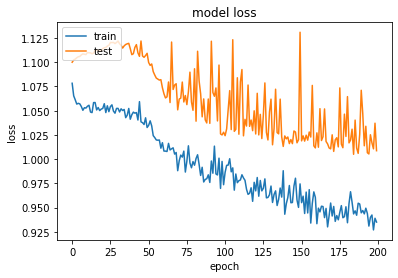

In [ ]:
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

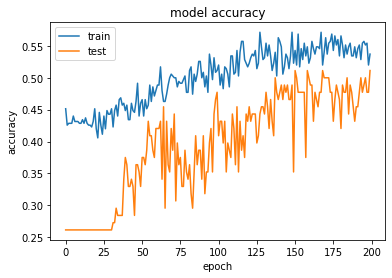

In [ ]:
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

##Model serialisation

In [ ]:
#save model and weights
model_name="Speech.h1"
save_dir=os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
model_path=os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s '%model_path)

#save the model to disk
model_json=model.to_json()
with open("model_json_aug.json", "w") as json_file:
  json_file.write(model_json)

INFO:tensorflow:Assets written to: /content/saved_models/Speech.h1/assets
Save model and weights at /content/saved_models/Speech.h1 


##Model Validation

In [ ]:
#loading json and model architecture
json_file=open('model_json_aug.json','r')
loaded_model_json=json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)

#load weights into new model
loaded_model.load_weights('saved_models/Speech.h1')
print("Loaded model from disk")

#keras optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
score=loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%"%(loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 51.14%


In [ ]:
preds=loaded_model.predict(x_test, batch_size=16, verbose=1)

preds=preds.argmax(axis=1)
preds

6/6 [==============================] - 0s 5ms/step


array([1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 1, 2, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2])

In [ ]:
#predictions
preds=preds.astype(int).flatten()
preds=(lb.inverse_transform((preds)))
preds=pd.DataFrame({'predictedvalues':preds})

#actual labels
actual=y_test.argmax(axis=1)
actual=actual.astype(int).flatten()
actual=(lb.inverse_transform((actual)))
actual=pd.DataFrame({'actualvalues':actual})

preds[:10]

,predictedvalues
0,english
1,spanish
2,spanish
3,english
4,spanish
5,spanish
6,english
7,spanish
8,spanish
9,english


In [ ]:
actual[:10]

,actualvalues
0,spanish
1,arabic
2,spanish
3,spanish
4,spanish
5,spanish
6,english
7,arabic
8,spanish
9,spanish
